Predict the existence of edges between nodes. 

Positive edges (existing connections).
Negative edges (non-existent connections) for training.

In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.nn
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops


/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Applications/anaconda3/lib/python3.11/site-packages/torch_sparse/_convert_cpu.so, 0x0006): symbol not found in flat namespace '__ZN2at8internal15invoke_parallelExxxRKNSt3__18functionIFvxxEEE'
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
node_features = pd.read_csv('preprocessed_node_features.csv')

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_98511/3506719987.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [3]:
edge_features = pd.read_csv('preprocessed_edge_features.csv')

In [4]:
node_features_numeric = node_features.select_dtypes(include=['number', 'bool'])  # Include numeric and boolean columns

if 'root_id' in node_features_numeric.columns:
    node_features_numeric = node_features_numeric.drop(columns=['root_id'])



In [5]:
node_features_tensor = torch.tensor(node_features_numeric.values, dtype=torch.float)

In [6]:
id_to_index = {root_id: idx for idx, root_id in enumerate(node_features['root_id'])} # PyTorch Geometric GNN works with nodes referenced by integer indices not arbitrary IDs

edge_features['pre_root_id'] = edge_features['pre_root_id'].map(id_to_index)
edge_features['post_root_id'] = edge_features['post_root_id'].map(id_to_index)

# Remove rows with unmapped IDs
edge_features = edge_features.dropna(subset=['pre_root_id', 'post_root_id']).astype({'pre_root_id': int, 'post_root_id': int})

edge_index = torch.tensor(edge_features[['pre_root_id', 'post_root_id']].values.T, dtype=torch.long) # standard edge representation used in PyTorch Geometric


In [7]:
labels = torch.tensor(node_features['nt_type'].factorize()[0], dtype=torch.long)

In [8]:
data = Data(
    x=node_features_tensor,
    edge_index=edge_index
)

In [9]:
data.y = torch.tensor(labels, dtype=torch.long) # true labels

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_98511/2186120499.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(labels, dtype=torch.long) # true labels


In [10]:
from torch_geometric.utils import negative_sampling

# Get positive edges (existing edges)
positive_edge_index = data.edge_index

# Generate negative edges
num_nodes = data.x.size(0)
negative_edge_index = negative_sampling(
    edge_index=positive_edge_index,
    num_nodes=num_nodes,
    num_neg_samples=positive_edge_index.size(1)
)

# Combine positive and negative edges
edges = torch.cat([positive_edge_index, negative_edge_index], dim=1)
labels = torch.cat([torch.ones(positive_edge_index.size(1)), torch.zeros(negative_edge_index.size(1))])


In [11]:
from sklearn.model_selection import train_test_split

# Split edges and labels
train_edges, test_edges, train_labels, test_labels = train_test_split(
    edges.t(), labels, test_size=0.2, random_state=42
)
train_edges, val_edges, train_labels, val_labels = train_test_split(
    train_edges, train_labels, test_size=0.2, random_state=42
)

# Convert back to edge_index format for PyTorch Geometric
train_edge_index = train_edges.t()
val_edge_index = val_edges.t()
test_edge_index = test_edges.t()


In [12]:
class LinkPredictionGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LinkPredictionGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# decoder
def link_prediction_decoder(z, edge_index):
    src, dst = edge_index
    return (z[src] * z[dst]).sum(dim=1)


In [17]:
num_nodes = len(data.y)

indices = torch.randperm(num_nodes)

train_size = int(0.7 * num_nodes)
val_size = int(0.2 * num_nodes)
test_size = num_nodes - train_size - val_size  # Remaining for test

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Assign indices to data object
data.train_indices = train_indices
data.val_indices = val_indices
data.test_indices = test_indices


In [18]:
def filter_edges_and_remap(edge_index, node_indices):
    # mapping from old node indices to new ones
    node_idx_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}
    
    # Mask edges where both nodes are in node_indices
    mask = torch.isin(edge_index[0], node_indices) & torch.isin(edge_index[1], node_indices)
    filtered_edge_index = edge_index[:, mask]

    # Remap edges to the new index space
    remapped_edge_index = torch.stack([
        torch.tensor([node_idx_map[idx.item()] for idx in filtered_edge_index[0]]),
        torch.tensor([node_idx_map[idx.item()] for idx in filtered_edge_index[1]])
    ], dim=0)

    return remapped_edge_index

# Split data
train_data = data.clone()
train_data.x = data.x[train_indices]
train_data.edge_index = filter_edges_and_remap(data.edge_index, train_indices)
train_data.y = data.y[train_indices]

val_data = data.clone()
val_data.x = data.x[val_indices]
val_data.edge_index = filter_edges_and_remap(data.edge_index, val_indices)
val_data.y = data.y[val_indices]

test_data = data.clone()
test_data.x = data.x[test_indices]
test_data.edge_index = filter_edges_and_remap(data.edge_index, test_indices)
test_data.y = data.y[test_indices]

# DataLoaders
train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
val_loader = DataLoader([val_data], batch_size=32, shuffle=False)
test_loader = DataLoader([test_data], batch_size=32, shuffle=False)


In [20]:
input_dim = data.x.size(1)
hidden_dim = 64
model = LinkPredictionGNN(input_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []
val_accuracies = []

test_accuracies = []

# Training 
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    
    for batch in train_loader: 
        optimizer.zero_grad()
        
        z = model(data.x, train_edge_index)
        pred = link_prediction_decoder(z, train_edge_index)
        loss = loss_fn(pred, train_labels.float())
        
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        for batch in val_loader: 

            z = model(data.x, val_edge_index)
            val_pred = link_prediction_decoder(z, val_edge_index)
            val_loss = loss_fn(val_pred, val_labels.float()).item()
            
            # Compute metrics
            val_pred_labels = (torch.sigmoid(val_pred) > 0.5).long()
            accuracy = (val_pred_labels == val_labels).float().mean().item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 161016.9375, Val Loss: 69605.6875, Val Acc: 0.5003
Epoch 2, Train Loss: 67065.4688, Val Loss: 25754.6719, Val Acc: 0.5003
Epoch 3, Train Loss: 24739.3672, Val Loss: 10916.7051, Val Acc: 0.5001
Epoch 4, Train Loss: 10209.3076, Val Loss: 9627.6074, Val Acc: 0.5001
Epoch 5, Train Loss: 8723.9023, Val Loss: 12534.2773, Val Acc: 0.5001
Epoch 6, Train Loss: 11339.8193, Val Loss: 15244.7764, Val Acc: 0.5001
Epoch 7, Train Loss: 13985.0029, Val Loss: 16333.2520, Val Acc: 0.5001
Epoch 8, Train Loss: 14897.2012, Val Loss: 15832.4736, Val Acc: 0.5001
Epoch 9, Train Loss: 14448.7979, Val Loss: 14209.2607, Val Acc: 0.5001
Epoch 10, Train Loss: 12949.4941, Val Loss: 11948.6475, Val Acc: 0.5001
Epoch 11, Train Loss: 10904.1035, Val Loss: 9507.5498, Val Acc: 0.5001
Epoch 12, Train Loss: 8651.8730, Val Loss: 7243.5952, Val Acc: 0.5001
Epoch 13, Train Loss: 6518.9097, Val Loss: 5368.1055, Val Acc: 0.5001
Epoch 14, Train Loss: 4834.8496, Val Loss: 3957.0806, Val Acc: 0.5001
Epoch 15,

In [21]:
# Test model
model.eval()
with torch.no_grad():
    z = model(data.x, test_edge_index)
    test_pred = link_prediction_decoder(z, test_edge_index)
    
    test_pred_labels = (torch.sigmoid(test_pred) > 0.5).long()
    test_accuracy = (test_pred_labels == test_labels).float().mean().item()
    print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5348


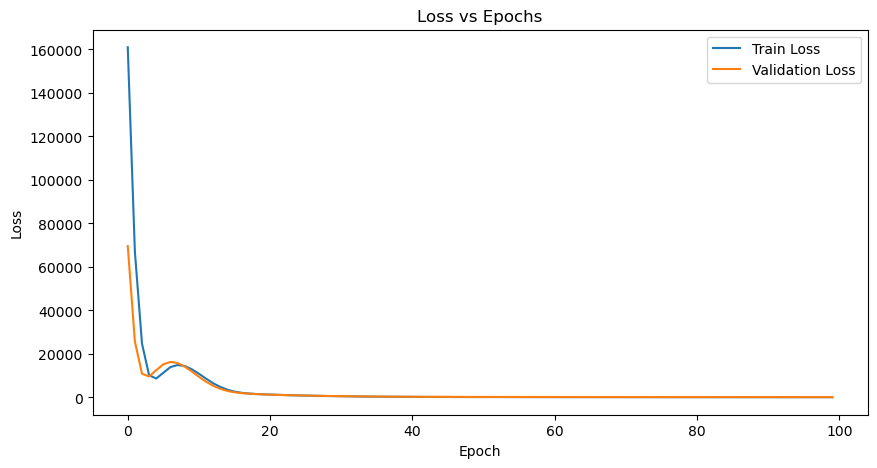

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

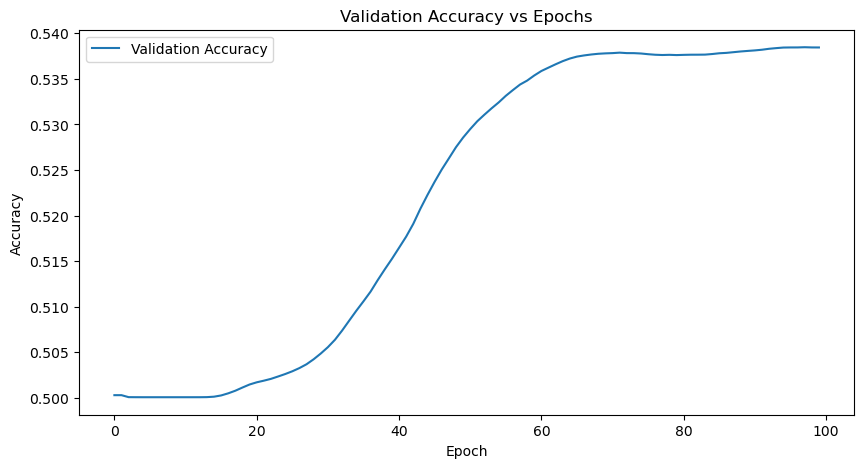

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.savefig('val_link_pred_gcn.png')
plt.show()